**CONVOLUTIONAL NEURAL NETWORK (**CNN**)**

**IMPORT TENSORFLOW**

---



In [1]:
# Importing dependancies
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers.experimental import preprocessing

**Download and prepare the CIFAR10 dataset**


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [2]:
(car_images, car_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
car_images, test_images = car_images / 255.0, test_images / 255.0

170508288/170498071 [==============================] - 2s 0us/step


**Verify the data**

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.

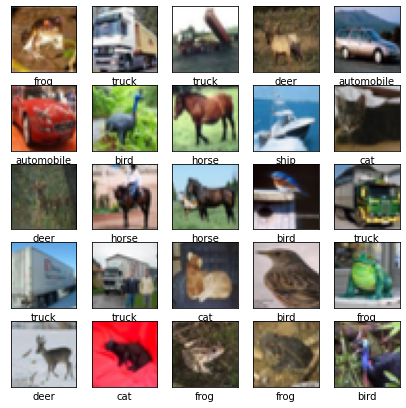

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(7,7))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(car_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[car_labels[i][0]])
plt.show()

In [7]:
# To read and preprocess the image
def load_and_preprocess(img):
  # Resizing the image
  img = tf.image.resize(img, (224, 224))
  
  return img

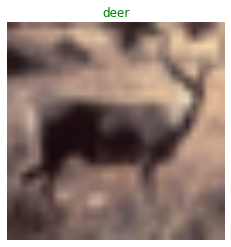

In [8]:
# Plotting a random image
rnd_num = np.random.choice(50000)
plt.imshow(load_and_preprocess(car_images[rnd_num]), cmap=plt.cm.binary)
plt.axis(False)
plt.title(class_names[car_labels[rnd_num][0]], color="green");

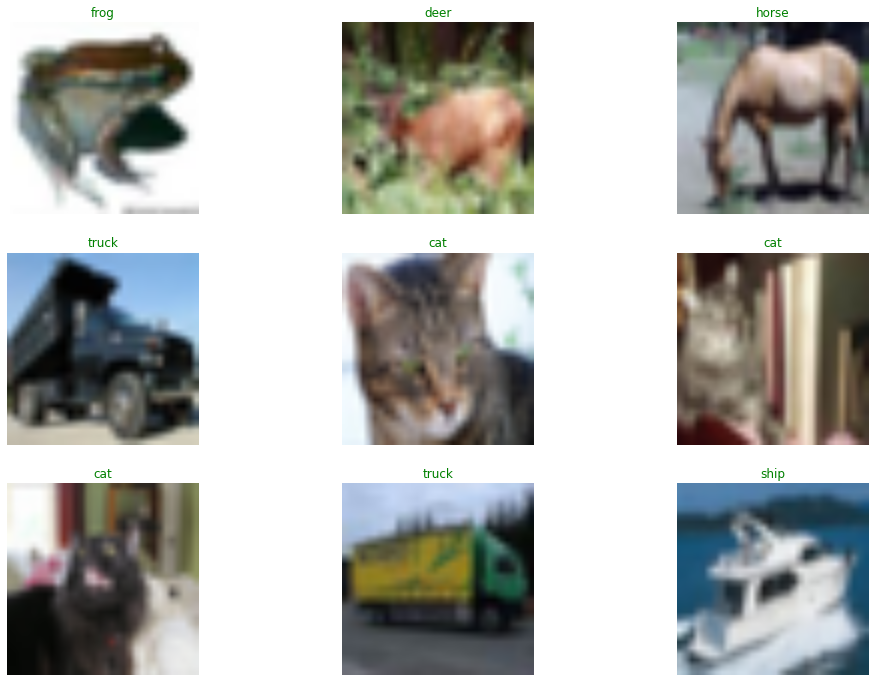

In [9]:
# Plotting multiple random images
plt.figure(figsize=(17, 12))
for i in range(9):
  # Random selecting an image from the train dataset
  rnd_num = np.random.choice(50000)
  img = load_and_preprocess(car_images[rnd_num])

  # Plotting the random images
  plt.subplot(3, 3, i+1)
  plt.title(class_names[car_labels[rnd_num][0]], color="green")
  plt.axis(False)
  plt.imshow(img);

In [10]:
# Creating data augmentation layer
data_augmentation = tf.keras.Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomZoom(0.2),
   preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name="data_augmentation_layer")

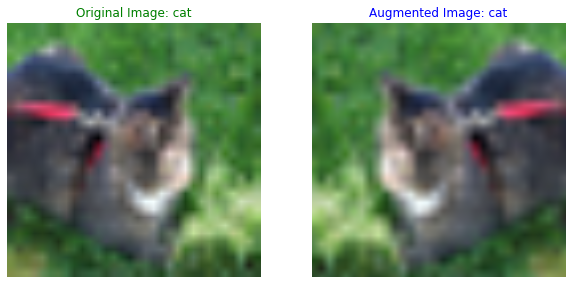

In [11]:
# Visualizing the augmentated image with the original image
rnd_num = np.random.choice(50000)
img = load_and_preprocess(car_images[rnd_num])
aug_img = data_augmentation(tf.expand_dims(img, axis=0))
aug_img = tf.image.resize(aug_img[0], (224, 224))
label = class_names[car_labels[rnd_num][0]]

plt.figure(figsize=(10, 7))
# Plot for original image
plt.subplot(1, 2, 1)
plt.title(f"Original Image: {label}", color = "green")
plt.axis(False)
plt.imshow(img)

# Plot for augmented image
plt.subplot(1, 2, 2)
plt.title(f"Augmented Image: {label}", color = "blue")
plt.axis(False)
plt.imshow(aug_img);

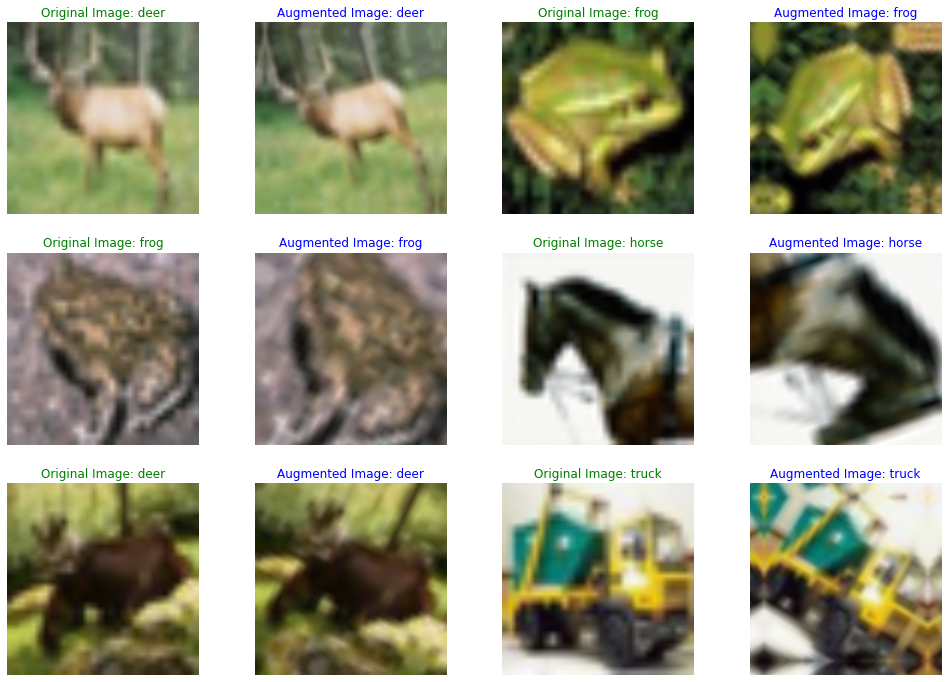

In [13]:
# Visualizing multiple augmentated images with original images
plt.figure(figsize=(17, 12))
for i in range(1, 12, 2):
  # generating random img & aug img
  rnd_num = np.random.choice(50000)
  img = load_and_preprocess(car_images[rnd_num])
  aug_img = data_augmentation(tf.expand_dims(img, axis=0))
  aug_img = tf.image.resize(aug_img[0], (224, 224))
  label = class_names[car_labels[rnd_num][0]]
  
  # plotting the original image
  plt.subplot(3, 4, i)
  plt.title(f"Original Image: {label}", color = "green")
  plt.axis(False)
  plt.imshow(img)
  
  # plotting the augmented image
  plt.subplot(3, 4, i+1)
  plt.title(f"Augmented Image: {label}", color = "blue")
  plt.axis(False)
  plt.imshow(aug_img);

**Create the convolutional base**

The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument input_shape to our first layer.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 5)))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))

Let's display the architecture of our model so far.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

**Add Dense layers on top**

To complete our model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of our model.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

As you can see, our (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

**Compile and Train the model**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(car_images, car_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 58s 37ms/step - loss: 0.9382 - accuracy: 0.6738 - val_loss: 0.9565 - val_accuracy: 0.6656
Epoch 2/10
1563/1563 [==============================] - 58s 37ms/step - loss: 0.8585 - accuracy: 0.7008 - val_loss: 0.9106 - val_accuracy: 0.6908
Epoch 3/10
1563/1563 [==============================] - 59s 37ms/step - loss: 0.7911 - accuracy: 0.7254 - val_loss: 0.8707 - val_accuracy: 0.7035
Epoch 4/10
1563/1563 [==============================] - 58s 37ms/step - loss: 0.7376 - accuracy: 0.7409 - val_loss: 0.9102 - val_accuracy: 0.6856
Epoch 5/10
1563/1563 [==============================] - 58s 37ms/step - loss: 0.6785 - accuracy: 0.7631 - val_loss: 0.8467 - val_accuracy: 0.7087
Epoch 6/10
1563/1563 [==============================] - 59s 37ms/step - loss: 0.6364 - accuracy: 0.7787 - val_loss: 0.9102 - val_accuracy: 0.6928
Epoch 7/10
1563/1563 [==============================] - 59s 37ms/step - loss: 0.5952 - accuracy: 0.7922 - val_loss: 0.8849 -

**Evaluate the Model**

313/313 - 3s - loss: 0.9436 - accuracy: 0.7105


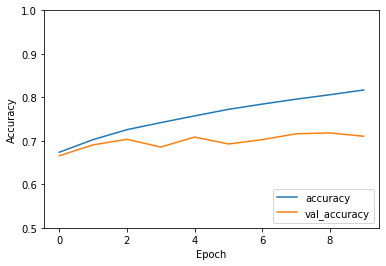

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([1.0, 2])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
print(test_acc)

0.7105000019073486


Our simple CNN has achieved a test accuracy of over 71%. Not bad for a few lines of code! For another CNN style, see an example using the Keras subclassing API.